## 3.2. 线性回归的从零开始实现

在了解线性回归的关键思想之后，我们可以开始通过代码来动手实现线性回归了。 在这一节中，我们将从零开始实现整个方法， 包括数据流水线、模型、损失函数和小批量随机梯度下降优化器。 虽然现代的深度学习框架几乎可以自动化地进行所有这些工作，但从零开始实现可以确保我们真正知道自己在做什么。 同时，了解更细致的工作原理将方便我们自定义模型、自定义层或自定义损失函数。 在这一节中，我们将只使用张量和自动求导。 在之后的章节中，我们会充分利用深度学习框架的优势，介绍更简洁的实现方式。


### 3.2.1. 生成数据集
为了简单起见，我们将根据带有噪声的线性模型构造一个人造数据集。 我们的任务是使用这个有限样本的数据集来恢复这个模型的参数。 我们将使用低维数据，这样可以很容易地将其可视化。 在下面的代码中，我们生成一个包含1000个样本的数据集， 每个样本包含从标准正态分布中采样的2个特征。 我们的合成数据集是一个矩阵$X∈R^{1000×2}$。
我们使用线性模型参数$w=[2,−3.4]^T$、$b=4.2$和噪声项$ϵ$生成数据集及其标签：
$$y=Xw+b+ϵ$$
$\epsilon$是一个均值为0、标准差为0.01的正态随机变量, 可以视为模型预测和标签时的潜在观测误差。 在这里我们认为标准假设成立，即$\epsilon$服从均值为0的正态分布。 为了简化问题，我们将标准差设为0.01。 下面的代码生成合成数据集。

In [54]:
import random
import tools_func as d2l
from mxnet import autograd, np, npx

npx.set_np()

# 生成数据集
def synthetic_data(w, b, num_examples):
    """生成y=Xw+b+噪声"""
    X = np.random.normal(0, 1, (num_examples, len(w)))
    y = np.dot(X, w) + b
    y += np.random.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = np.array([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

print('features:', features[0],'\nlabel:', labels[0])


features: [-0.28166404  1.6381967 ] 
label: [-1.9302081]


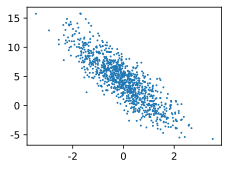

In [55]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].asnumpy(), labels.asnumpy(), 1);

### 3.2.2. 读取数据集
回想一下，训练模型时要对数据集进行遍历，每次抽取一小批量样本，并使用它们来更新我们的模型。 由于这个过程是训练机器学习算法的基础，所以有必要定义一个函数， 该函数能打乱数据集中的样本并以小批量方式获取数据。
在下面的代码中，我们定义一个data_iter函数， 该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量。 每个小批量包含一组特征和标签。



In [56]:
def data_iter(batch_size, features, labels):
    """
    创建一个数据迭代器，用于以指定的批量大小遍历数据集。

    参数:
    batch_size -- 每个批次的数据数量。
    features -- 数据集中的特征数组。
    labels -- 数据集中的标签数组。

    返回:
    一个生成器，每次产生一个包含批量特征和批量标签的元组。
    """
    # 获取数据集中的样本数量
    num_examples = len(features)
    # 为所有样本创建一个索引列表
    indices = list(range(num_examples))
    # 随机打乱索引顺序，以便在遍历数据时增加随机性
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    # 遍历数据集，每次取出一个批量大小的样本
    for i in range(0, num_examples, batch_size):
        # 获取当前批次的索引，确保不超过数据集的边界
        batch_indices = np.array(
            indices[i: min(i + batch_size, num_examples)])
        # 根据批次索引获取对应的特征和标签，并作为生成器的输出
        yield features[batch_indices], labels[batch_indices]    # yield 不会中断循环

通常，我们利用GPU并行运算的优势，处理合理大小的“小批量”。 每个样本都可以并行地进行模型计算，且每个样本损失函数的梯度也可以被并行计算。 GPU可以在处理几百个样本时，所花费的时间不比处理一个样本时多太多。

我们直观感受一下小批量运算：读取第一个小批量数据样本并打印。 每个批量的特征维度显示批量大小和输入特征数。 同样的，批量的标签形状与batch_size相等。

In [57]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

[[ 0.22131035 -0.20516203]
 [ 0.2692147  -1.2575098 ]
 [ 0.73122406 -0.12548408]
 [ 1.3126847   0.8228546 ]
 [ 1.0170366   0.2247866 ]
 [ 0.07354335  0.26300442]
 [-0.22626275  1.0019622 ]
 [-0.4360659  -1.4884167 ]
 [ 0.88355076 -0.3955517 ]
 [-0.08705859 -0.13188636]] 
 [[5.3443484 ]
 [9.014755  ]
 [6.0724387 ]
 [4.041507  ]
 [5.4709153 ]
 [3.4408948 ]
 [0.34242967]
 [8.391781  ]
 [7.324264  ]
 [4.461969  ]]


当我们运行迭代时，我们会连续地获得不同的小批量，直至遍历完整个数据集。 上面实现的迭代对教学来说很好，但它的执行效率很低，可能会在实际问题上陷入麻烦。 例如，它要求我们将所有数据加载到内存中，并执行大量的随机内存访问。 在深度学习框架中实现的内置迭代器效率要高得多， 它可以处理存储在文件中的数据和数据流提供的数据。

### 3.2.3. 初始化模型参数

在我们开始用小批量随机梯度下降优化我们的模型参数之前， 我们需要先有一些参数。 在下面的代码中，我们通过从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重， 并将偏置初始化为0。

In [58]:
w = np.random.normal(0, 0.01, (2, 1))   # 初始化权重
b = np.zeros(1) # 初始化偏置

# 将权重偏置初始化为梯度计算所需要的变量
w.attach_grad() 
b.attach_grad()

在初始化参数之后，我们的任务是更新这些参数，直到这些参数足够拟合我们的数据。 每次更新都需要计算损失函数关于模型参数的梯度。 有了这个梯度，我们就可以向减小损失的方向更新每个参数。 因为手动计算梯度很枯燥而且容易出错，所以没有人会手动计算梯度。 我们使用 2.5节中引入的自动微分来计算梯度。

### 3.2.4. 定义模型
接下来，我们必须定义模型，将模型的输入和参数同模型的输出关联起来。 回想一下，要计算线性模型的输出， 我们只需计算输入特征$\mathbf{X}$和模型权重$\mathbf{w}$的矩阵-向量乘法后加上偏置$b$。 注意，上面的$\mathbf{Xw}$是一个向量，而$b$是一个标量。 回想一下广播机制（2.2节），加法广播了$b$，使之变成一个与$\mathbf{Xw}$形状相同的矩阵。

In [59]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return np.dot(X, w) + b

### 3.2.5. 定义损失函数

因为需要计算损失函数的梯度，所以我们应该先定义损失函数。 这里我们使用 3.1节中描述的平方损失函数。 在实现中，我们需要将真实值y的形状转换为和预测值y_hat的形状相同。
损失函数的公式为: $l(\hat{y}, y) = \frac{1}{2}(\hat{y} - y)^2$
这个其实就是均方误差，我们在前面的章节中已经介绍过了。

In [60]:
def squared_loss(y_hat, y):
    """均方损失"""
    # y.reshape(y_hat.shape) 保证了真实值y和预测值y_hat的形状一致
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

### 3.2.6. 定义优化算法

正如我们在 3.1节中讨论的，线性回归有解析解。 尽管线性回归有解析解，但本书中的其他模型却没有。 这里我们介绍小批量随机梯度下降。

在每一步中，使用从数据集中随机抽取的一个小批量，然后根据参数计算损失的梯度。 接下来，朝着减少损失的方向更新我们的参数。 下面的函数实现小批量随机梯度下降更新。 该函数接受模型参数集合、学习速率和批量大小作为输入。每 一步更新的大小由学习速率lr决定。 因为我们计算的损失是一个批量样本的总和，所以我们用批量大小（batch_size） 来规范化步长，这样步长大小就不会取决于我们对批量大小的选择。


In [61]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    for param in params:
        param[:] = param - lr * param.grad / batch_size

### 3.2.7. 训练

现在我们已经准备好了模型训练所有需要的要素，可以实现主要的训练过程部分了。 理解这段代码至关重要，因为从事深度学习后， 相同的训练过程几乎一遍又一遍地出现。 在每次迭代中，我们读取一小批量训练样本，并通过我们的模型来获得一组预测。 计算完损失后，我们开始反向传播，存储每个参数的梯度。 最后，我们调用优化算法sgd来更新模型参数。

概括一下，我们将执行以下循环：
- 初始化参数
- 重复以下训练，直到完成
    - 计算梯度 $\mathbf{g} \leftarrow \partial_{(\mathbf{w}, b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
    - 更新参数 $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

在每个迭代周期（epoch）中，我们使用data_iter函数遍历整个数据集， 并将训练数据集中所有样本都使用一次（假设样本数能够被批量大小整除）。 这里的迭代周期个数num_epochs和学习率lr都是超参数，分别设为3和0.03。 设置超参数很棘手，需要通过反复试验进行调整。 我们现在忽略这些细节，以后会在 11节中详细介绍。

In [62]:
lr = 0.03
num_epochs = 5
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        with autograd.record():
            l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 计算l关于[w,b]的梯度
        l.backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    train_l = loss(net(features, w, b), labels)
    print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.036355
epoch 2, loss 0.000129
epoch 3, loss 0.000047
epoch 4, loss 0.000047
epoch 5, loss 0.000047


In [63]:
# 因为我们使用的是自己合成的数据集，所以我们知道真正的参数是什么。 
# 因此，我们可以通过比较真实参数和通过训练学到的参数来评估训练的成功程度。 事实上，真实参数和通过训练学到的参数确实非常接近。
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')
print(f"估计值: {w}, {b}")

w的估计误差: [0.00035024 0.00066876]
b的估计误差: [0.00063515]
估计值: [[ 1.9996498]
 [-3.4006689]], [4.1993647]


注意，我们不应该想当然地认为我们能够完美地求解参数。 在机器学习中，我们通常不太关心恢复真正的参数，而更关心如何高度准确预测参数。 幸运的是，即使是在复杂的优化问题上，随机梯度下降通常也能找到非常好的解。 其中一个原因是，在深度网络中存在许多参数组合能够实现高度精确的预测。

### 3.2.8. 小结

我们学习了深度网络是如何实现和优化的。在这一过程中只使用张量和自动微分，不需要定义层或复杂的优化器。

这一节只触及到了表面知识。在下面的部分中，我们将基于刚刚介绍的概念描述其他模型，并学习如何更简洁地实现其他模型。